# CNN and LSTM seismic maps estimation
Following  the tutorial by Jason Brownlee:

https://machinelearningmastery.com/how-to-develop-convolutional-neural-networks-for-multi-step-time-series-forecasting/
and 
https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

Ensemble Deep Learning Models
https://machinelearningmastery.com/stacking-ensemble-for-deep-learning-neural-networks/


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Convolution2D, MaxPooling2D, LSTM
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from pandas import read_csv
from os import makedirs
from keras.utils.vis_utils import plot_model
from sklearn.metrics import r2_score
%matplotlib inline

Using TensorFlow backend.


## 1. Read and prepare dataset

### 1.1. Read and create dataset

In [2]:
# load all data
dataset = read_csv('gif6_imagen.csv')

In [3]:
# Prepare Dataset
dataset.drop(['Unnamed: 0'], axis=1, inplace=True)
#Turn Dataframe into Array
dataset = dataset.values

#Create dataset full of zeros
gif = np.zeros((6575,42,15))
#arrange dataset for CNN
for i in range (6575):
    gif[i,:,:] = dataset[:, i*15:i*15+15]

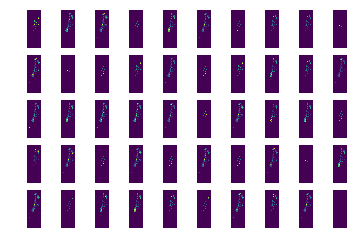

In [4]:
#Plot 25 random images from dataset
np.random.seed(20)
l=np.random.choice(np.arange(len(gif)),50).reshape(5,10)
fig, ax = plt.subplots(nrows=5,ncols=10, sharex=True, sharey=True)
for x in range(5):
    for y in range(10):
        ax[x,y].imshow(gif[l[x,y]])
        ax[x,y].axis('off')

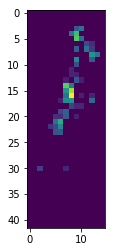

In [6]:
#Show one image
plt.imshow(gif[6003,:,:])

### 1.2. Prepare dataset

In [5]:
#Scale dataset in [0,1]
min = np.min(gif)
max = np.max(gif)
gif = (gif-min)/(max-min)
#print("Min:", np.min(gif), "-- Max", np.max(gif))

# reduce floating point to 32 bits
gif = gif.astype('float32')

In [6]:
#Define function to create dataset
def create_dataset(g, look_back=1, look_forward=1):
    X, Y = [], []
    for i in range(len(g)-look_back-1-look_forward):
        a = gif[i:(i+look_back),:,:]
        a = np.transpose(a, (1,2,0))
        X.append(a)
        b = g[(i+look_back):(i+look_back+look_forward),:,:]
        b1 = np.max(b)
        b2 = float(np.round(np.array(np.where(b == np.max(b)))/6, 0)[1][0])
        Y.append([b1, b2])
    return np.array(X), np.array(Y)

In [7]:
# Create X and Y
# reshape into X=(t-1,..., t-7) and Y=max(t, t+1, ..., t+6)
look_back = 30
look_forward = 6
X, Y = create_dataset(gif, look_back, look_forward)
X = np.array(X)
Y = np.array(Y)

# split into train and test sets
train_size = int(len(X) * 0.75)
test_size = len(X) - train_size
Xtrain, Xtest = X[0:train_size,:,:,:], X[train_size:len(X),:,:,:]
Ytrain, Ytest = Y[0:train_size,:], Y[train_size:len(Y),:]
print("Training data size:", train_size, "-- Test data size:", test_size)

#Split into Y1 and Y2 sets for separate modelling
Y1train, Y1test = Ytrain[:,0], Ytest[:,0]
Y2train, Y2test = Ytrain[:,1], Ytest[:,1]

#Convert Y2 into categorical
Y2train = to_categorical(Y2train, 6)
Y2test = to_categorical(Y2test, 6)

# Split into X1 and X2 sets for separate modelling
# X1train
X1train = []
for i in range (len(Xtrain)):
    a = []
    for j in range (look_back):
        a.append(np.max(Xtrain[i,:,:,j]))
    X1train.append(a)

# X1test
X1test = []
for i in range (len(Xtest)):
    b = []
    for j in range (look_back):
        b.append(np.max(Xtest[i,:,:,j]))
    X1test.append(b)

X1train = np.array(X1train)
X1test = np.array(X1test)

X2train = Xtrain
X2test = Xtest

# reshape input to be [samples, time steps, features]
X1train = np.reshape(X1train, (X1train.shape[0], X1train.shape[1], 1))
X1test = np.reshape(X1test, (X1test.shape[0], X1test.shape[1], 1))

Training data size: 4903 -- Test data size: 1635


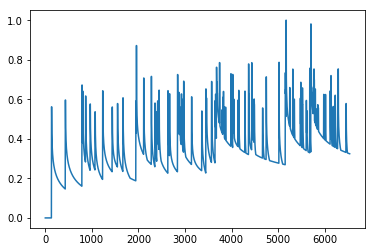

In [60]:
plt.plot(Y[:,0])

## 2. Modelling

### 2.1. Regression Model with LSTM nets

#### 2.1.1. Estimate Trend

In [10]:
# create the LSTM network
batch_size = 1
look_back = look_back
model1 = Sequential()
#model1.add(LSTM(100, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
#model1.add(LSTM(50, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
#model1.add(LSTM(25, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
model1.add(LSTM(100, batch_input_shape=(batch_size, look_back, 1), stateful=True))
#model1.add(LSTM(50, stateful=True))
model1.add(Dense(1))
model1.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])

#Plot the net (Commented if not working) pydot.find_graphviz()
plot_model(model1, to_file='lstm1_plot.png', show_shapes=True)

In [9]:
# To Checkpoint the model
filepath="LSTM_2_100_30t_gif6.weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

# Fit model
model1.fit(X1train, Y1train, validation_split=0.33, epochs=15, batch_size=batch_size, verbose=1, shuffle=True, callbacks=callbacks_list)

NameError: name 'model1' is not defined

In [11]:
#Load best model
# load weights
model1.load_weights("LSTM100_30_gif6.weights.best.hdf5")
# Compile model (required to make predictions)
model1.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
print("Created model and loaded weights from file")

Created model and loaded weights from file


In [12]:
# make predictions
trainPredict = model1.predict(X1train, batch_size=batch_size)
model1.reset_states()
testPredict = model1.predict(X1test, batch_size=batch_size)

# Convert back to original scale
trainPredict = trainPredict * (max - min) + min
Y1train = Y1train * (max - min) + min
testPredict = testPredict*(max - min) + min
Y1test = Y1test * (max - min) + min

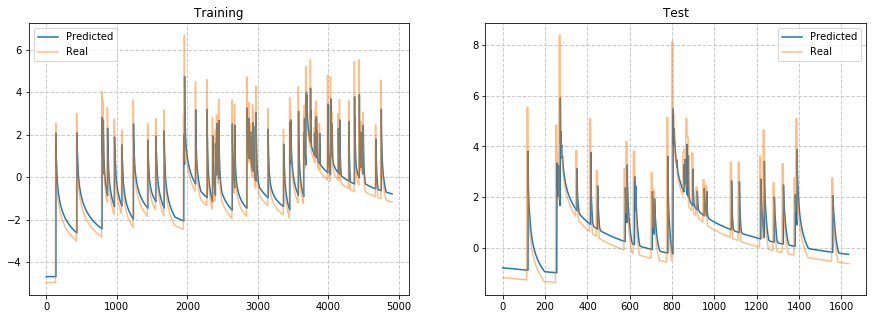

In [24]:
# Plot results
fig,axes = plt.subplots(1 ,2, sharex=False, sharey=False, figsize=(15,5))
axes[0].plot(trainPredict)
axes[0].plot(Y1train, alpha=0.5)
axes[0].set_title('Training')
axes[0].grid(color='0.8', linestyle='--', linewidth=1)
axes[0].legend(['Predicted', 'Real'])
axes[1].plot(testPredict)
axes[1].plot(Y1test, alpha=0.5)
axes[1].set_title('Test')
axes[1].grid(color='0.8', linestyle='--', linewidth=1)
axes[1].legend(['Predicted', 'Real'])


In [81]:
#Scores
score_train_LSTM = mean_squared_error(Y1train, trainPredict)
score_test_LSTM = mean_squared_error(Y1test, testPredict)
r2_train_LSTM = r2_score(Y1train, trainPredict)
r2_test_LSTM = r2_score(Y1test, testPredict)
print("MSE \n Training: %.4f \t Test: %.4f"%(score_train_LSTM, score_test_LSTM))
print("R2 \n Training: %.4f \t Test: %.4f"%(r2_train_LSTM, r2_test_LSTM))

MSE 
 Training: 1.2663 	 Test: 1.5951
R2 
 Training: 0.5828 	 Test: 0.4161


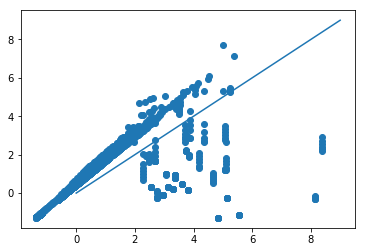

In [23]:
from numpy.polynomial.polynomial import polyfit
plt.scatter(Y1test,1.3*testPredict)
x = np.arange(10)
y = x
plt.plot(x,y)

 ...]

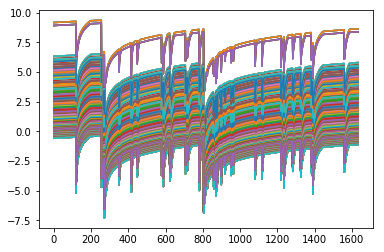

In [20]:
error = Y1test - testPredict
plt.plot(error)

### 2.2. Categorical CNN Model

In [55]:
# Define CNN model
model2 = Sequential()
model2.add(Convolution2D(12,(5,5),padding='same',activation='relu',input_shape=(42,15,look_back)))
model2.add(MaxPooling2D())
model2.add(Convolution2D(18,(5,5),padding='same',activation='relu'))
model2.add(MaxPooling2D())
model2.add(Convolution2D(24,(3,3),padding='same',activation='relu'))
model2.add(MaxPooling2D())
model2.add(Convolution2D(32,(3,3),padding='same',activation='relu'))
model2.add(Flatten()) #Reduciendo dimensionalidad
model2.add(Dropout(0.25))
model2.add(Dense(1024,activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(256,activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(64,activation='relu'))
model2.add(Dense(6,activation='softmax'))

model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Plot the net (Commented if not working) pydot.find_graphviz()
plot_model(model2, to_file='cnn_plot.png', show_shapes=True)

In [56]:
# To Checkpoint the model
filepath="CNN2_gif6.weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

# Fit model
batch_size = 32
model2.fit(X2train, Y2train, validation_split=0.33, epochs=15, batch_size=batch_size, verbose=1, shuffle=True, callbacks=callbacks_list)

Train on 3285 samples, validate on 1618 samples
Epoch 1/15
 448/3285 [===>..........................] - ETA: 2:09 - loss: 1.5930 - acc: 0.3415

KeyboardInterrupt: 

In [57]:
#Load best model
# load weights
model2.load_weights("CNN_gif6.weights.best.hdf5")
# Compile model (required to make predictions)
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Created model and loaded weights from file")

ValueError: Dimension 0 in both shapes must be equal, but are 5 and 18. Shapes are [5,5,12,18] and [18,12,3,3]. for 'Assign_72' (op: 'Assign') with input shapes: [5,5,12,18], [18,12,3,3].

In [51]:
score=model2.evaluate(X2test,Y2test,verbose=1)
print("\n Loss: %.4f \t Accuracy: %.4f"%(score[0],score[1]))

1635/1635 [==============================] - 3s 2ms/step

 Loss: 1.8156 	 Accuracy: 0.4924
